# Physics 256
## The Poisson Equation

\begin{equation}
\nabla \cdot \vec{E} = \frac{\rho}{\varepsilon_0}
\end{equation}


## Last Time

- Relaxation methods including:
 - Jacobi method
 - Guass-Seidel method
- Computing the electric field

## Today

- Simultaneous over relaxation (SOR)
- Application to the Poisson equation (finite charge density)

## Setting up the Notebook

In [2]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.style.use('notebook');
%config InlineBackend.figure_format = 'retina'
colors = ["#2078B5", "#FF7F0F", "#2CA12C", "#D72827", "#9467BE", "#8C574B",
            "#E478C2", "#808080", "#BCBE20", "#17BED0", "#AEC8E9", "#FFBC79", 
            "#98E08B", "#FF9896", "#C6B1D6", "#C59D94", "#F8B7D3", "#C8C8C8", 
           "#DCDC8E", "#9EDAE6"]

## Jacobi and Gauss-Seidel Methods

Last time, we derived iterative relaxation methods to solve the Laplace equation in two dimensions:

\begin{equation}
V(i,j) = \frac{1}{4} \left[V(i+1,j) + V(i-1,j) + V(i,j+1) + V(i,j-1)  \right].
\end{equation}

Both had poor $\mathrm{O}(N^2)$ scaling and have limited applicability for fine grids.  The main advance of Gauss-Seidel was to update the potential *in place* using new values as they become available.  We can extend this idea to take a *larger* relaxation step.

## Simultaneous Over Relaxtion (SOR)

At each grid point $(i,j)$ we defined

\begin{equation}
\Delta V(i,j) = V_{\rm new} (i,j) - V_{\rm old}(i,j)
\end{equation}

where $V_{\rm new}$ is computed with the expression above. The Gauss-Seidel method can then be written as:

\begin{equation}
V_{\rm new}(i,j) = V_{\rm old}(i,j) + \alpha \Delta V(i,j) 
\end{equation}

where $\alpha = 1$.  However, we can arbitrarily increase the value of $\alpha$, in particular:

\begin{align}
\alpha = 1 \quad & : \quad \rm {Gauss-Seidel} \newline
1 < \alpha < 2 \quad & : \quad \rm {SOR} \newline
\alpha \ge 2 \quad & : \quad \rm {Unstable}.
\end{align}

The optimal value of $1 < \alpha < 2$ to use depends on the particular proglem.  For elliptical PDEs with Dirichlet boundary condtiions it can be estimated as:

\begin{equation}
\alpha \approx \frac{2}{1+\pi/L}.
\end{equation}


### Coding

Starting from the expression above, it is convenient to write:
\begin{align}
V_{\rm new}(i,j) &= V_{\rm old}(i,j) + \alpha \Delta V(i,j) \newline &= \frac{\alpha}{4} \left[V(i+1,j) + V(i-1,j) + V(i,j+1) + V(i,j-1)  \right] + (1-\alpha)V(i,j) .
\end{align}

Let's code it up.

In [ ]:
def SOR_update(V,α,mask):
    '''Update the potential according to the Simultaneous-Over-Relaxation method.'''
    
    # here we use a mask which tells us which elements should be updated
    ΔV = 0.0
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            if mask[i,j]:
                V_old = V[i,j]
                V[i,j] = (α/4)*(V[i-1,j] + V[i+1,j] + V[i,j+1] + V[i,j-1]) + (1-α)*V_old
                ΔV += abs(V_old-V[i,j])

    return ΔV

## Box inside a Box

Find the potential everywhere the nested box shown below.  We assume that the inner box spans -1/5 ... 1/5 in the $x$ and $y$ directions.

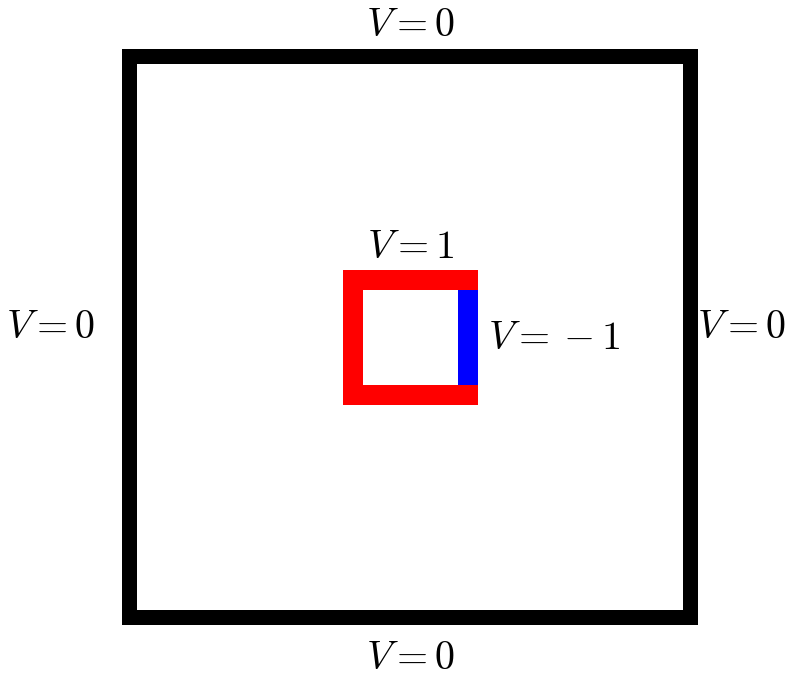

In [3]:
plt.axis('off')
plt.plot((-1,-1),(-1,1),'k', lw=15)
plt.plot((1,1),(-1,1),'k', lw=15)
plt.plot((-1,1),(1,1),'k', lw=15)
plt.plot((-1,1),(-1,-1),'k', lw=15)

plt.plot((-0.2,-0.2),(-0.2,0.2),'r', lw=10)
plt.plot((0.2,0.2),(-0.2,0.2),'b', lw=10)
plt.plot((-0.2,0.2),(0.2,0.2),'r', lw=10)
plt.plot((-0.2,0.2),(-0.2,-0.2),'r', lw=10)

cV = [0,0,0,0]
for i,loc in enumerate([(-1.25,0),(0,-1.15),(1.15,0),(0,1.05)]):
    plt.text(*loc,r'$V=%d$'%cV[i], fontsize=20, ha='center')

plt.text(0,0.28,r'$V=1$', fontsize=20, ha='center')
plt.text(0.5,0.0,r'$V=-1$', fontsize=20, va ='center', ha='center')

plt.axes().set_aspect('equal')

###  Initialze the potential

In [ ]:
def init(N):
    '''Initialize the potential with boundary conditions.'''

    # the potential
    V  = np.zeros([N,N])
    
    # the mask
    mask = np.ones([N,N], dtype=int)

    # set the boundary conditions 
    box_min = int(N/2) - int(0.5*N/5)
    box_max = int(N/2) + int(0.5*N/5)
    
    V[box_min:box_max,box_min] = 1
    V[box_min:box_max,box_max] = -1
    V[box_min,box_min:box_max] = 1
    V[box_max,box_min:box_max] = 1
        
    # set the mask
    mask[box_min:box_max,box_min] = 0
    mask[box_min:box_max,box_max] = 0
    mask[box_min,box_min:box_max] = 0
    mask[box_max,box_min:box_max] = 0
    mask[:,0] = 0
    mask[:,-1] = 0
    mask[0,:] = 0
    mask[-1,:] = 0

    return V,mask

###  Iterate until convergence

In [ ]:
%matplotlib notebook
from matplotlib import animation

# the number of lattice points in the x and y direction
N = 51

# the tolerance for convergence
ϵ = 1.0E-5

# the over-relaxation parameter
α = 1.9

# initialize 
V,mask = init(N)

# Plot the initial configuration
fig = plt.figure(figsize=(7,4))
plt.xlabel('x')
plt.ylabel('y')
ims = [[plt.imshow(V, cmap=plt.get_cmap('bwr'), animated=True)]]
cb = plt.colorbar(label='Electric Potential', pad=0.1)


# Iterate until convergence
n = 0
ΔV = 1.0

while ΔV/(N*N) > ϵ:
    ΔV = SOR_update(V,α,mask)
    
    # plot the intermediate results
    if n < 200:
        ims.append([plt.imshow(V, extent=[-1,1,-1,1], cmap=plt.get_cmap('bwr'), animated=True)])
        
    if n > 1000: 
        break
    n+= 1\

print("ΔV = %8.5E in %d steps" % ((ΔV/N**2),n))
# animate the final result
anim = animation.ArtistAnimation(fig, ims, interval=10, blit=False, repeat_delay=1, repeat=True)

## The Poisson Equation

So far we have used relaxation methods to solve the Laplace equation, i.e. we find the potential in the absence of any charges.  When we have some fixed charge density, we must solve the Poisson equation:

\begin{equation}
\nabla^2 V = \frac{\rho(x,y,z)}{\varepsilon_0}
\end{equation}

where $\rho(x,y,z)$ is the charge density and $\varepsilon_0$ is the permittivity of free space.  Performing the same discretization procedure as before and taking an isotropic grid: $\Delta x = \Delta y = \Delta z = \Delta$ we find:

\begin{equation}
V(i,j,k) = \frac{1}{6} \left[V(i+1,j,k) + V(i-1,j,k) + V(i,j+1,k) + V(i,j-1,k) +V(i,j,k+1) + V(i,j,k-1) \right] + \frac{\rho(i,j,k)\Delta^2}{6\varepsilon_0}.
\end{equation}

The choice of boundary conditions can be a bit tricky in these problems.

<div class="span alert alert-success">
<h2> Team Programming challenge </h2>

Find the potential due to a single charge at the origin with $q = \Delta \varepsilon_0$ thus $\rho(0,0,0) = q/\Delta^3 =  \varepsilon_0 /\Delta^2$.
<br /><br />

<strong>Hint: </strong> Carefully consider your boundary conditions.  What should the potential be for $r\gg 1$?
</div>

<!-- 
                    V[i,j,k] = (α/6)*(V[i-1,j,k] + V[i+1,j,k] + V[i,j+1,k] + V[i,j-1,k] + 
                                      V[i,j,k+1] + V[i,j,k-1] + ρ[i,j,k]*Δ**2) + (1-α)*V_old
                                      
-->

In [ ]:
def init_poisson(N,Δ):
    '''Initialize the potential with boundary conditions.'''

    # midpoint
    mid = int(N/2)
    
    # potential, charge density and mask
    V  = np.zeros([N,N,N],dtype=float)
    ρ = np.zeros_like(V)
    mask = np.ones([N,N,N],dtype=int)
    
    ###
    # INITIALIZE MASK
    ###
    
    ###
    # INITIALIZE ρ
    ###

    return V,ρ,mask


In [ ]:
def SOR_update_3D(V,ρ,α,Δ,mask):
    '''Update the potential according to the Simultaneous-Over-Relaxation method.'''
    
    # here we use a mask which tells us which elements should be updated
    ΔV = 0.0
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            for k in range(mask.shape[2]):
                if mask[i,j,k]:
                    V_old = V[i,j,k]
                    ###
                    # INSERT CODE HERE
                    ###

                    ΔV += abs(V_old-V[i,j,k])
    return ΔV

In [ ]:
%matplotlib inline

# the number of lattice points in each direction
N = 11

# box and grid size
L = 1.0
Δ = L/N

# the tolerance for convergence
ϵ = 1.0E-5

# the over-relaxation parameter
α = 1.5

# initialize 
V,ρ,mask = init_poisson(N,Δ)

# Iterate until convergence
ΔV = 100.0
while ΔV/(N**3) > ϵ:
    ### 
    # INSERT CODE HERE
    ###

print("ΔV = %8.5E in %d steps" % ((ΔV/N**3),n))

# plot the final result as a contour plot
X,Y = np.meshgrid(np.linspace(-L/2,L/2,N), np.linspace(-L/2,L/2,N))
cs = plt.contourf(X,Y,np.transpose(V[:,:,int(N/2)]),10,cmap=plt.get_cmap('bwr'))
cb = plt.colorbar(label='Electric Potential', pad=0.1)
plt.xlabel('x')
plt.ylabel('y')
plt.axes().set_aspect('equal')